# All imports #

In [1]:
from __future__ import print_function

import sys, os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf
import tensorflow.keras
import pandas as pd
import numpy as np
import sklearn
import keras
import csv

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Input

from keras_uncertainty.models import MCDropoutClassifier, MCDropoutRegressor
from keras_uncertainty.utils import numpy_regression_nll
from keras_uncertainty.models import DeepEnsembleRegressor, deep_ensemble_regression_nll_loss, SimpleEnsemble



/home/dfki.uni-bremen.de/bmanickavasakan/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/dfki.uni-bremen.de/bmanickavasakan/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/dfki.uni-bremen.de/bmanickavasakan/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/d

In [21]:
def load_joint_space_csv_chunks(file_path):
    data_frame = pd.read_csv(file_path, skiprows=1, header=None)
    del data_frame[18]
    return data_frame

def load_task_space_csv_chunks(file_path):
    return pd.read_csv(file_path, skiprows=1, header=None)


In [22]:
##please select the appropriate folder, willl use os.path.join() for completed script
TRAIN_FOLDER = '/home/dfki.uni-bremen.de/bmanickavasakan/newdataset_rh5_leg/leg_5steps/'
TEST_FOLDER = '/home/dfki.uni-bremen.de/bmanickavasakan/newdataset_rh5_leg/leg_5steps/test_4steps'

X_TRAIN_FILE = os.path.join(TRAIN_FOLDER, 'leg_forwardkinematics_x.csv')
Q_TRAIN_FILE = os.path.join(TRAIN_FOLDER, 'leg_sysstate_q.csv')
x_train = load_task_space_csv_chunks(X_TRAIN_FILE)
q_train = load_joint_space_csv_chunks(Q_TRAIN_FILE)

X_TEST_FILE = os.path.join(TEST_FOLDER, 'leg_forwardkinematics_x.csv')
Q_TEST_FILE = os.path.join(TEST_FOLDER, 'leg_sysstate_q.csv')
x_test = load_task_space_csv_chunks(X_TEST_FILE)
q_test = load_joint_space_csv_chunks(Q_TEST_FILE)

# Splitting the dataset with SD #

In [23]:
'''

Standard deviation based data splitting

We consider the Q features and use the feature with the 

highest SD for dividing the dataset
'''

stats_q_train = pd.DataFrame()
stats_q_train["Mean"] = q_train.mean()
stats_q_train["Var"] = q_train.var()
stats_q_train["STD"] = q_train.std()
stats_q_train["OneSigmaMax"] = stats_q_train["Mean"] + stats_q_train["STD"]
stats_q_train["OneSigmaMin"] = stats_q_train["Mean"] - stats_q_train["STD"]
stats_q_train.T

max_std = stats_q_train["STD"].max()
colomn_max_std = stats_q_train["STD"].idxmax()

maximum = stats_q_train.loc[colomn_max_std, "Mean"] + (1.5 * max_std)
minimum = stats_q_train.loc[colomn_max_std, "Mean"] - (1.5 * max_std)
print(maximum, minimum)

InDistribution_Q_Train = q_train[q_train[colomn_max_std].le(maximum) & q_train[colomn_max_std].ge(minimum)]
OutDistribution_Q_Train = q_train[q_train[colomn_max_std].ge(maximum) | q_train[colomn_max_std].le(minimum)]
InDistribution_X_Train = x_train[q_train[colomn_max_std].le(maximum) & q_train[colomn_max_std].ge(minimum)]
OutDistribution_X_Train = x_train[q_train[colomn_max_std].ge(maximum) | q_train[colomn_max_std].le(minimum)]

InDistribution_Q_Test = q_test[q_test[colomn_max_std].le(maximum) & q_test[colomn_max_std].ge(minimum)]
OutDistribution_Q_Test = q_test[q_test[colomn_max_std].ge(maximum) | q_test[colomn_max_std].le(minimum)]
InDistribution_X_Test = x_test[q_test[colomn_max_std].le(maximum) & q_test[colomn_max_std].ge(minimum)]
OutDistribution_X_Test = x_test[q_test[colomn_max_std].ge(maximum) | q_test[colomn_max_std].le(minimum)]

x_train_1 = InDistribution_X_Train
q_train_1 = InDistribution_Q_Train
x_test_1 = InDistribution_X_Test
q_test_1 = InDistribution_Q_Test

OOD_x_train = OutDistribution_X_Train
OOD_q_train = OutDistribution_Q_Train
OOD_x_test = OutDistribution_X_Test
OOD_q_test = OutDistribution_Q_Test

print("//////////////////////")
print(x_train_1.shape, OOD_x_train.shape, x_test_1.shape, OOD_x_test.shape)


0.9119140506494964 -0.5558160506494813
//////////////////////
(13750, 9) (1875, 9) (3840, 9) (256, 9)


In [24]:

x_scaler = MinMaxScaler()
q_scaler = MinMaxScaler()

#In order training set
x_train_1 = x_scaler.fit_transform(x_train_1)
q_train_1 = q_scaler.fit_transform(q_train_1)

#complete test set
x_test = x_scaler.transform(x_test)
q_test = q_scaler.transform(q_test)

#split testing data
IOD_x_test = x_scaler.transform(x_test_1)
IOD_q_test = q_scaler.transform(q_test_1)

OOD_x_test = x_scaler.transform(OOD_x_test)
OOD_q_test = q_scaler.transform(OOD_q_test)

In [25]:
print(IOD_x_test[0])

[8.88403205e-01 6.52137067e-01 6.71030535e-01 4.60491315e-01
 3.23972785e-02 3.98426058e-01 4.34750101e-01 2.35521144e-04
 7.25466835e-04]


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(q_test)
df_result = pd.DataFrame()
df_result[0] = tsne_results[:,0]
df_result[1] = tsne_results[:,1]

plt.figure()
sns.scatterplot(data=df_result)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 4096 samples in 0.008s...
[t-SNE] Computed neighbors for 4096 samples in 0.233s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4096
[t-SNE] Computed conditional probabilities for sample 2000 / 4096
[t-SNE] Computed conditional probabilities for sample 3000 / 4096
[t-SNE] Computed conditional probabilities for sample 4000 / 4096
[t-SNE] Computed conditional probabilities for sample 4096 / 4096
[t-SNE] Mean sigma: 0.408712
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.388878
[t-SNE] KL divergence after 300 iterations: 1.617017


<AxesSubplot:>

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3840 samples in 0.004s...
[t-SNE] Computed neighbors for 3840 samples in 0.300s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3840
[t-SNE] Computed conditional probabilities for sample 2000 / 3840
[t-SNE] Computed conditional probabilities for sample 3000 / 3840
[t-SNE] Computed conditional probabilities for sample 3840 / 3840
[t-SNE] Mean sigma: 0.406737
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.778221
[t-SNE] KL divergence after 300 iterations: 1.566312


<AxesSubplot:>

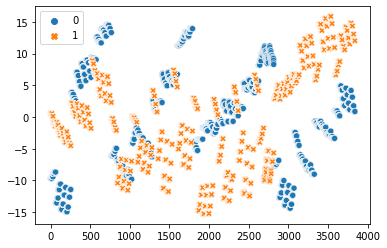

In [8]:
tsne_results = tsne.fit_transform(IOD_q_test)
df_result_1 = pd.DataFrame()
df_result_1[0] = tsne_results[:,0]
df_result_1[1] = tsne_results[:,1]

plt.figure()
sns.scatterplot(data=df_result_1)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 256 samples in 0.001s...
[t-SNE] Computed neighbors for 256 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 256 / 256
[t-SNE] Mean sigma: 0.471318
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.612968
[t-SNE] KL divergence after 300 iterations: 0.576743


<AxesSubplot:>

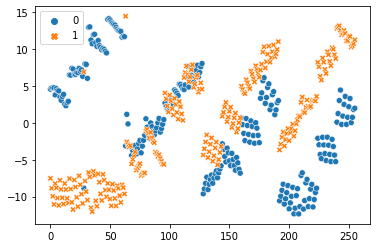

In [9]:
tsne_results = tsne.fit_transform(OOD_q_test)
df_result_2 = pd.DataFrame()
df_result_2[0] = tsne_results[:,0]
df_result_2[1] = tsne_results[:,1]

plt.figure()
sns.scatterplot(data=df_result_2)

In [26]:

def model_builder():
    input_shape = 9
    output_shape = 18
    depth = 6
    width = 64
    reduction_factor = 0.9
    for i in range(depth):
        num_neurons = max(int(width * (reduction_factor ** i)), 4)
        if i == 0:
            inp = Input(shape=(input_shape,))
            x = Dense(num_neurons, activation='relu')(inp)
        else:
            x = Dense(num_neurons, activation='relu')(x)
            
    mean = Dense(output_shape, activation="sigmoid")(x)
    var = Dense(output_shape, activation="softplus")(x)
    
    train_model = Model(inp, mean)
    pred_model = Model(inp, [mean, var])

    train_model.compile(loss=deep_ensemble_regression_nll_loss(var), optimizer="adam", metrics=["mae"])
    return train_model, pred_model

In [27]:


model = model_builder

print(type(model))

<class 'function'>


In [28]:


with tf.device('/cpu:0'):
    ensemble_model = DeepEnsembleRegressor(model_builder, 3)
    ensemble_model.fit(x_train_1, q_train_1, epochs = 100, batch_size = 128, verbose = 1, validation_data=(IOD_x_test, IOD_q_test))

Train on 13750 samples, validate on 3840 samples
Epoch 1/100
13750/13750 [==============================] - 1s 41us/sample - loss: -0.2948 - mean_absolute_error: 0.2755 - val_loss: -0.4596 - val_mean_absolute_error: 0.2504
Epoch 2/100
13750/13750 [==============================] - 0s 18us/sample - loss: -0.5501 - mean_absolute_error: 0.2345 - val_loss: -0.5963 - val_mean_absolute_error: 0.2332
Epoch 3/100
13750/13750 [==============================] - 0s 19us/sample - loss: -0.6247 - mean_absolute_error: 0.2218 - val_loss: -0.6424 - val_mean_absolute_error: 0.2199
Epoch 4/100
13750/13750 [==============================] - 0s 19us/sample - loss: -0.6762 - mean_absolute_error: 0.2097 - val_loss: -0.6482 - val_mean_absolute_error: 0.2105
Epoch 5/100
13750/13750 [==============================] - 0s 19us/sample - loss: -0.7123 - mean_absolute_error: 0.2033 - val_loss: -0.6190 - val_mean_absolute_error: 0.2067
Epoch 6/100
13750/13750 [==============================] - 0s 20us/sample - loss:

13750/13750 [==============================] - 0s 18us/sample - loss: -1.3592 - mean_absolute_error: 0.1023 - val_loss: 1.8434 - val_mean_absolute_error: 0.1083
Epoch 95/100
13750/13750 [==============================] - 0s 19us/sample - loss: -1.3622 - mean_absolute_error: 0.1019 - val_loss: 1.7413 - val_mean_absolute_error: 0.1068
Epoch 96/100
13750/13750 [==============================] - 0s 18us/sample - loss: -1.3596 - mean_absolute_error: 0.1017 - val_loss: 1.9995 - val_mean_absolute_error: 0.1065
Epoch 97/100
13750/13750 [==============================] - 0s 18us/sample - loss: -1.3732 - mean_absolute_error: 0.1007 - val_loss: 1.2575 - val_mean_absolute_error: 0.1077
Epoch 98/100
13750/13750 [==============================] - 0s 19us/sample - loss: -1.3571 - mean_absolute_error: 0.1008 - val_loss: 1.3760 - val_mean_absolute_error: 0.1062
Epoch 99/100
13750/13750 [==============================] - 0s 18us/sample - loss: -1.3789 - mean_absolute_error: 0.0997 - val_loss: 1.8946 - v

Epoch 41/100
13750/13750 [==============================] - 0s 19us/sample - loss: -2.0676 - mean_absolute_error: 0.0583 - val_loss: -1.9253 - val_mean_absolute_error: 0.0596
Epoch 42/100
13750/13750 [==============================] - 0s 19us/sample - loss: -2.0757 - mean_absolute_error: 0.0577 - val_loss: -1.8992 - val_mean_absolute_error: 0.0602
Epoch 43/100
13750/13750 [==============================] - 0s 19us/sample - loss: -2.0767 - mean_absolute_error: 0.0576 - val_loss: -1.9080 - val_mean_absolute_error: 0.0593
Epoch 44/100
13750/13750 [==============================] - 0s 18us/sample - loss: -2.0837 - mean_absolute_error: 0.0569 - val_loss: -1.9156 - val_mean_absolute_error: 0.0587
Epoch 45/100
13750/13750 [==============================] - 0s 19us/sample - loss: -2.0955 - mean_absolute_error: 0.0563 - val_loss: -1.9137 - val_mean_absolute_error: 0.0583
Epoch 46/100
13750/13750 [==============================] - 0s 19us/sample - loss: -2.0857 - mean_absolute_error: 0.0562 - va

Epoch 88/100
13750/13750 [==============================] - 0s 19us/sample - loss: -2.3134 - mean_absolute_error: 0.0471 - val_loss: -1.7464 - val_mean_absolute_error: 0.0564
Epoch 89/100
13750/13750 [==============================] - 0s 19us/sample - loss: -2.2986 - mean_absolute_error: 0.0474 - val_loss: -1.8334 - val_mean_absolute_error: 0.0534
Epoch 90/100
13750/13750 [==============================] - 0s 19us/sample - loss: -2.2951 - mean_absolute_error: 0.0474 - val_loss: -1.8130 - val_mean_absolute_error: 0.0556
Epoch 91/100
13750/13750 [==============================] - 0s 19us/sample - loss: -2.3085 - mean_absolute_error: 0.0472 - val_loss: -1.9305 - val_mean_absolute_error: 0.0523
Epoch 92/100
13750/13750 [==============================] - 0s 19us/sample - loss: -2.3105 - mean_absolute_error: 0.0470 - val_loss: -1.7982 - val_mean_absolute_error: 0.0545
Epoch 93/100
13750/13750 [==============================] - 0s 18us/sample - loss: -2.3284 - mean_absolute_error: 0.0466 - va

Epoch 81/100
13750/13750 [==============================] - 0s 20us/sample - loss: -1.7916 - mean_absolute_error: 0.0580 - val_loss: -1.2931 - val_mean_absolute_error: 0.0621
Epoch 82/100
13750/13750 [==============================] - 0s 19us/sample - loss: -1.7926 - mean_absolute_error: 0.0578 - val_loss: -1.1925 - val_mean_absolute_error: 0.0623
Epoch 83/100
13750/13750 [==============================] - 0s 19us/sample - loss: -1.8012 - mean_absolute_error: 0.0576 - val_loss: -1.2471 - val_mean_absolute_error: 0.0618
Epoch 84/100
13750/13750 [==============================] - 0s 19us/sample - loss: -1.7929 - mean_absolute_error: 0.0578 - val_loss: -1.3014 - val_mean_absolute_error: 0.0619
Epoch 85/100
13750/13750 [==============================] - 0s 19us/sample - loss: -1.7911 - mean_absolute_error: 0.0578 - val_loss: -1.1226 - val_mean_absolute_error: 0.0633
Epoch 86/100
13750/13750 [==============================] - 0s 18us/sample - loss: -1.7973 - mean_absolute_error: 0.0575 - va

In [29]:
mean_test, sd_test = ensemble_model.predict(x_test)
mean_test = q_scaler.inverse_transform(mean_test)
q_test_unorm = q_scaler.inverse_transform(q_test)
print("NLL: {:.5f}".format(numpy_regression_nll(q_test_unorm, mean_test, sd_test**2)))

NLL: -1.20797


In [30]:
mean_test_IOD, sd_test_IOD = ensemble_model.predict(IOD_x_test)
mean_test_IOD = q_scaler.inverse_transform(mean_test_IOD)
#sd_test_IOD = q_scaler.inverse_transform(sd_test_IOD)
q_test_unorm = q_scaler.inverse_transform(IOD_q_test)
global_mae = mean_absolute_error(q_test_unorm, mean_test_IOD)
print(global_mae)
print("NLL: {:.5f}".format(numpy_regression_nll(q_test_unorm, mean_test_IOD, sd_test_IOD**2)))

0.0412091031050779
NLL: -1.22079


In [31]:
mean_test_OOD, sd_test_OOD = ensemble_model.predict(OOD_x_test)
mean_test_OOD = q_scaler.inverse_transform(mean_test_OOD)
#sd_test_OOD = q_scaler.inverse_transform(sd_test_OOD)
q_test_unorm = q_scaler.inverse_transform(OOD_q_test)
global_mae = mean_absolute_error(q_test_unorm, mean_test_OOD)
print(global_mae)
print("NLL: {:.5f}".format(numpy_regression_nll(q_test_unorm, mean_test_OOD, sd_test_OOD**2)))

0.06597720160656119
NLL: -1.01566


In [48]:
col_no = 2

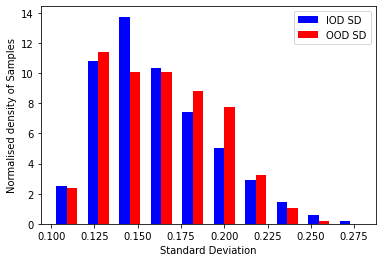

In [49]:
sd_test_IOD_df = pd.DataFrame(sd_test_IOD)
sd_test_OOD_df = pd.DataFrame(sd_test_OOD)
new_scores = np.concatenate([sd_test_IOD_df[col_no], sd_test_OOD_df[col_no]], axis=0)
minmaxscaler = MinMaxScaler()
new_scores_scaled = minmaxscaler.fit_transform(new_scores.reshape(-1, 1))

new_labels = np.concatenate([np.zeros_like(sd_test_IOD_df[col_no]), np.ones_like(sd_test_OOD_df[col_no])], axis=0)
histogram_df = pd.DataFrame(new_scores_scaled, new_labels)

#histogram_df.hist(column=0)

#sd_test_IOD_df.hist(column=0)
#sd_test_OOD_df.hist(column=0)
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

a_heights, a_bins = np.histogram(sd_test_IOD_df[col_no].values.reshape(-1, 1), density=True)
b_heights, b_bins = np.histogram(sd_test_OOD_df[col_no].values.reshape(-1, 1), bins=a_bins, density=True)

width = (a_bins[1] - a_bins[0])/3

ax.bar(a_bins[:-1], a_heights, width = width, facecolor='blue',label="IOD SD")
ax.bar(b_bins[:-1]+width, b_heights, width = width, facecolor='red', label="OOD SD")
ax.legend()
ax.set_xlabel("Standard Deviation")
ax.set_ylabel("Normalised density of Samples")
fig.savefig("density_vs_sd_ensemble_sd_split_col_1.pdf")

0.527886962890625


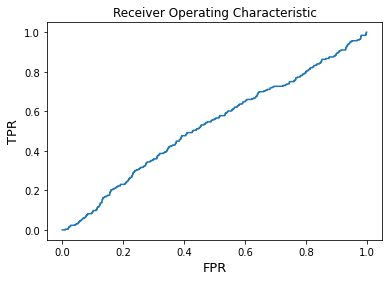

In [52]:
from sklearn.metrics import roc_curve, roc_auc_score
norm_scores = new_scores - min(new_scores) / (max(new_scores) - min(new_scores))

auc = roc_auc_score(new_labels, new_scores)
fpr, tpr, threshs = roc_curve(new_labels, norm_scores, drop_intermediate=True)
print(auc)
plt.xlabel('FPR', fontsize=13)
plt.ylabel('TPR', fontsize=13)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr)
plt.savefig("auc_ensemble_sd_split_col_1.pdf")
plt.show()


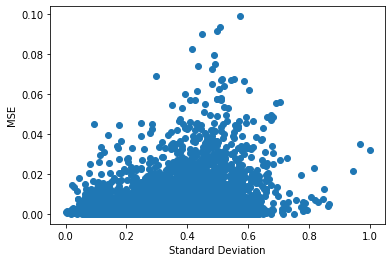

In [51]:
from sklearn.metrics import mean_squared_error

mean_test, sd_test = ensemble_model.predict(x_test)
mean_test = q_scaler.inverse_transform(mean_test)
#sd_test_IOD = q_scaler.inverse_transform(sd_test_IOD)
q_unorm = q_scaler.inverse_transform(q_test)

mean_test_df = pd.DataFrame(mean_test)
sd_test_df = pd.DataFrame(sd_test)
q_df = pd.DataFrame(q_test)

MEAN = np.array(mean_test_df[0])
SD = np.array(sd_test_df[0])
Q = np.array(q_df[0])
Q = Q.reshape(-1, 1)


mean_scaler = MinMaxScaler()
MEAN = mean_scaler.fit_transform(MEAN.reshape(-1, 1))
sd_scaler = MinMaxScaler()
SD = sd_scaler.fit_transform(SD.reshape(-1, 1))

MSE = np.square(np.subtract(Q, MEAN))
plt.figure()

plt.scatter(SD, MSE)
plt.xlabel('Standard Deviation')
plt.ylabel('MSE')
#plt.savefig("./Art.pdf")
plt.show()